In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prop
from pandas import DataFrame
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import ode, simpson
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# Исходные данные
D_sn = 0.195    # калибр снаряда
m_sn = 93       # масса снаряда
# скорость полета во время коррекции, м/с
V_sn_kor_min = 370
V_sn_kor_max = 410
# угловая скорость снаряда, об/с
nu_sn_min = 8
nu_sn_max = 10
I_kor = 140     # требуемый импульс коррекции
fi2_tel = np.deg2rad(120) # телесный угол коррекции
t_v = 1e-3      # = delta_t время выхода двигателя на режим
n_du = 18       # 18
m_du_max = 0.35 # максимальная масса одного ИДК
# кол-во коррекций: 6 (по 3 ДУ),   12 (6 по 2 ДУ + 6 по 1 ДУ),   18 (по 1 ДУ)
# угол наклона сопла: 25 градусов
# угол между осями ДУ: 60 градусов
T_min = 273.15 - 50
T_nom = 273.15 + 18
T_max = 273.15 + 50

mu_c = 0.95
kappa_pred = 180

p_atm = 101325

#### 1. Формирование недостающих исходных данных

L_max = 42.4
Время коррекции 0.033 ... 0.042 с
ksi = 0.660
Время горения заряда топлива: 0.018 c
Время последействия: 0.014 c


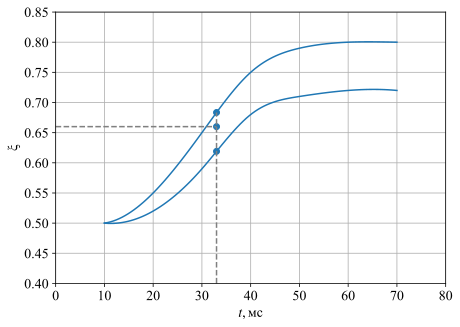

In [3]:
D_du = 45/1000  # диаметр ИДК

# максимальная длина ДУ
L_max = (D_sn / 2 - (np.sqrt(3) + np.tan(np.deg2rad(25))) / 2 * D_du - 2 * 3e-3) / np.cos(np.deg2rad(25)) - 4e-3
# L_max = 38e-3
print(f'L_max = {L_max*1e3:.1f}')
L_max = math.ceil(L_max * 1000) / 1000

# Определение времени работы ИДК
t_d_min = 1 / nu_sn_max * fi2_tel / (2 * np.pi)
t_d_max = 1 / nu_sn_min * fi2_tel / (2 * np.pi)
print(f'Время коррекции {t_d_min:.3f} ... {t_d_max:.3f} с')

# Окончательное время 
t_d = 0.033

# Коэффициент заполнения индикаторной кривой
ksi_max = interp1d(np.linspace(0.01,0.07,7),[0.5,0.55,0.65,0.75,0.79,0.8,0.8], kind = 'cubic')
ksi_min = interp1d(np.linspace(0.01,0.07,7),[0.5,0.52,0.59,0.68,0.71,0.72,0.72], kind= 'cubic')
# ksi = np.mean([ksi_min(t_d),ksi_max(t_d)])
ksi = 0.66
print(f'ksi = {ksi:.3f}')

t_g = t_d / 4 * (5 * ksi - 1) - 3/8 * t_v   # Время горения заряда топлива (первое приближение)
# t_g = math.ceil(t_g * 1000) / 1000
t_g = 0.018
t_p = t_d - t_v - t_g                       # Время последействия
print(f'Время горения заряда топлива: {t_g} c\nВремя последействия: {t_p:.3f} c')

plt.figure(figsize=(7, 5))
tds = np.linspace(0.01,0.07,100)
plt.plot(tds*1e3,ksi_min(tds), c = 'tab:blue')
plt.plot(tds*1e3,ksi_max(tds), c = 'tab:blue')
plt.plot([t_d*1e3, t_d*1e3], [0.4,ksi_max(t_d)], ls = '--', c = 'grey')
plt.plot([0,t_d*1e3],[ksi,ksi], ls = '--', c = 'grey')
plt.scatter([t_d*1e3, t_d*1e3, t_d*1e3], [ksi_min(t_d),ksi,ksi_max(t_d)])

plt.ylim(0.4,0.85)
plt.xlim(0,80)
plt.grid()
plt.xlabel('$\mathit{t}, мс$')
plt.ylabel('$\\xi$')
plt.savefig('ksi.svg', dpi=300, bbox_inches='tight')

plt.show()

In [4]:
np.tan(np.deg2rad(25)) * D_du / 2 * 1e3

10.491922308487467

In [5]:
# Назначим в первом приближении коэффициент расширения сопла
zeta = 1.4

# теоретический коэффициент тяги
K_tf = interp1d(np.linspace(1.4,2.6,7),[1.46,1.51,1.56,1.6,1.62,1.64,1.67])
K_t = K_tf(zeta) + 0
print(f'Теоретический коэффициент тяги {K_t}')

# потери
fi1 = 0.95
fi2 = 0.95

# Действительный коэффициент тяги
K_d = fi1 * fi2 * K_t
print(f'Действительный коэффициент тяги {K_d:.3f}')

Теоретический коэффициент тяги 1.46
Действительный коэффициент тяги 1.318


In [6]:
# Коэффициенты
K1 = 0.92
K2 = 1.08

# необходимая тяга
P_need = I_kor / (K1 * K2 * ksi * t_d) / np.cos(np.deg2rad(25))
print(f'Необходимая тяга {P_need:.2f}')

Необходимая тяга 7138.10


##### 1.6 Выбор марки топлива

In [7]:
propel = prop.get_propellant('B-3')
p1_max = 80e6
delta_st = max(np.round(1.3 * p1_max * D_du / (2 * 1000e6),4),1.2e-3)
D_km = np.round(D_du - 2 * delta_st,4)
print(f'Толщина стенки {delta_st*1e3:.1f} мм\n',
      f'Диаметр КС {D_km*1e3:.1f} мм')

# Из уравнения Бори находим минимальное и номинальное давления по одному заданному
def fun(x):
    p1N, p1_min = x[0], x[1]
    return [propel.u(p1_max,T_max) / p1_max - propel.F1(p1N/1e6) / p1N,
            propel.u(p1_max,T_max) / (p1_max * propel.F3(T_min)) - propel.F1(p1_min/1e6) / p1_min]

find_p1N = lambda p1N: propel.u(p1_max,T_max) / p1_max - propel.F1(p1N/1e6) / p1N
find_p1_min = lambda p1_min: propel.u(p1_max,T_max) / (p1_max * propel.F3(T_min)) - propel.F1(p1_min/1e6) / p1_min

p1N, p1_min = fsolve(fun,[0.7 * p1_max, 0.5 * p1_max])

print(f'p1N = {p1N/1e6:.3f} МПа\np1_min = {p1_min/1e6:.3f} МПа')

Толщина стенки 2.3 мм
 Диаметр КС 40.4 мм
p1N = 59.754 МПа
p1_min = 34.674 МПа


In [8]:
# Площадь критического сечения сопла
F_kr = P_need / (K_d * p1_min)
print(f'Площадь критики {F_kr*1e4:.3f} * 10^4 м2')

# диаметр критического сечения сопла
D_kr = np.sqrt(4 * F_kr / np.pi)
print(f'Диаметр критики {D_kr*1e3:.1f} мм')

fi_vx = np.deg2rad(70)
fi_c = np.deg2rad(20)

# Длины участков сопла
L1 = np.round((D_km - D_kr) / (2 * np.tan(fi_vx)),3)
L2 = 2e-3
L3 = np.round(D_kr/(2*np.tan(fi_c)) * (zeta - 1),4)

print(f'Длины блоков сопла: {L1,L2,L3}\n',
      f'Общая длина сопла: {(L1 + L2 + L3)*1e3:.0f} мм\n',
      f'Макс допуст длина заряда {L_max - (L1 + L2 + L3)}')

Площадь критики 1.562 * 10^4 м2
Диаметр критики 14.1 мм
Длины блоков сопла: (0.005, 0.002, 0.0078)
 Общая длина сопла: 15 мм
 Макс допуст длина заряда 0.028199999999999996


In [9]:
# Расчет газодинамических параметров в выходном сечении сопла

#вспомогательные гд функции
tau = lambda lmbd, k: 1 - (k - 1)/(k + 1)*lmbd**2
pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
eps = lambda lmbd, k: pi(lmbd,k) / tau(lmbd,k)
q = lambda lmbd, k:  ((k + 1) / 2)**(1 / (k - 1)) * lmbd * eps(lmbd, k)
nu = lambda lmbd, k: 1 / q(lmbd,k)
f = lambda lmbd, k: (lmbd**2 + 1) * (1 - (k - 1) / (k + 1) * lmbd**2) ** (1 / (k - 1))

A = lambda k: np.sqrt(k * ((2 / (k + 1))**((k + 1) / (k - 1))))

find_lambda_a = lambda lmbd: q(lmbd,propel.k) - 1 / zeta ** 2

lambda_a = fsolve(find_lambda_a,1.5)[0]
c_kr = np.sqrt(2 * propel.k / (propel.k + 1) * propel.R * propel.T0)
V_a = lambda_a * c_kr
p_a = pi(lambda_a,propel.k) * p1N
T_a = tau(lambda_a,propel.k) * propel.T0
rho_a = p_a / (propel.R * T_a)

print(f'Безразм скорость потока {lambda_a:.3f}\n',
      f'Критическая скорость звука {c_kr:.0f} м/с\n',
      f'Скорость {V_a:.0f} м/с\n',
      f'Давление {p_a/1e6:.3f} МПа\n',
      f'Температура {T_a:.0f} К\n',
      f'Плотность {rho_a:.2f} кг/м3')

Безразм скорость потока 1.772
 Критическая скорость звука 1076 м/с
 Скорость 1906 м/с
 Давление 6.994 МПа
 Температура 2005 К
 Плотность 10.32 кг/м3


In [10]:
G_p = mu_c * A(propel.k) * F_kr * p1_min / np.sqrt(propel.R * propel.T0)
omega_t = G_p * t_g
e_0 = 2 * np.round(propel.u(p1_min,T_min) * t_g,4)
S_g = omega_t / (propel.rho * propel.u(p1_min,T_min) * t_g)

def results_for_one_m(m):
    n = 1
    ki = 1
    while m > ki:
        n += 3 * (m - ki)
        ki += 2

    D_nar = (D_km - 1e-3) / m
    D_vn = D_nar - 2 * e_0
    L_zar = S_g / (np.pi * n * (D_nar + D_vn))
    kappa_vn = 4 * L_zar / D_vn
    kappa_nar = 4 * n * D_nar * L_zar / (D_km**2 - n * D_nar ** 2)
    eps_s = (D_nar ** 2 - D_vn ** 2) / D_km ** 2 * n
    Sh = 4 * F_kr / (np.pi * D_km**2 * (1 - eps_s))

    result = {
        'm': m,
        'n': n,
        'D_nar': np.round(D_nar*1e3,1),
        'D_vn': np.round(D_vn*1e3,1),
        'L_zar': np.round(L_zar*1e3),
        'kappa_vn': np.round(kappa_vn,2),
        'kappa_nar': np.round(kappa_nar,2),
        'eps_s': np.round(eps_s,3),
        'Sh': np.round(Sh,3),
        'pass': []
    }

    if D_vn <= 1.5e-3:
        result['pass'].append('D_вн')
    if L_zar > L_max - L1 - L2 - L3:
        result['pass'].append(f'L_з на {(L_zar - (L_max - L1 - L2 - L3))*1e3:.1f} мм')
    if kappa_vn > kappa_pred:
        result['pass'].append('к_вн')
    if kappa_nar > kappa_pred:
        result['pass'].append('к_нар')
    if eps_s <= 0.5:
        result['pass'].append('eps_s')
    if Sh >= 0.75:
        result['pass'].append('Sh')

    return result

print(f'Расход G = {G_p:.3f} кг/с\n',
      f'Масса топлива omega = {omega_t:.3f} кг\n',
      f'Толщина горящего свода e0 = {e_0*1e3:.1f} мм\n',
      f'Потребнаая площадь горения Sг = {S_g:.4f} м2')

Расход G = 2.919 кг/с
 Масса топлива omega = 0.042 кг
 Толщина горящего свода e0 = 0.7 мм
 Потребнаая площадь горения Sг = 0.0351 м2


In [11]:
A(propel.k)

0.6580647917517491

In [12]:
results = []
for m in range(3,13,2):
    results.append(results_for_one_m(m))

In [13]:
df_dict = {}
for data in results:
    df_dict[data['m']] = list(data.values())[1:]
df = DataFrame(df_dict,index = ['n','D_н','D_вн','L_з','к_вн','к_нар','eps_s','Sh','не подходит по'])

df

,3,5,7,9,11
n,7,19,37,61,91
D_н,13.1,7.9,5.6,4.4,3.6
D_вн,10.3,5.1,2.8,1.6,0.8
L_з,68.0,45.0,36.0,31.0,28.0
к_вн,26.34,35.74,50.51,77.99,143.99
к_нар,58.9,60.08,64.68,70.96,78.96
eps_s,0.282,0.422,0.537,0.623,0.681
Sh,0.17,0.211,0.263,0.323,0.382
не подходит по,"[L_з на 39.8 мм, eps_s]","[L_з на 17.2 мм, eps_s]",[L_з на 7.5 мм],[L_з на 2.6 мм],[D_вн]


In [14]:
itog = results[-2]
L_zar = itog['L_zar']/1e3
D_nar = itog['D_nar']/1e3
D_vn = itog['D_vn']/1e3
n_zar = itog['n']

##### Пересчет длины для размещения воспламенителя

Потребная длина заряда второго ряда = 36.5 мм


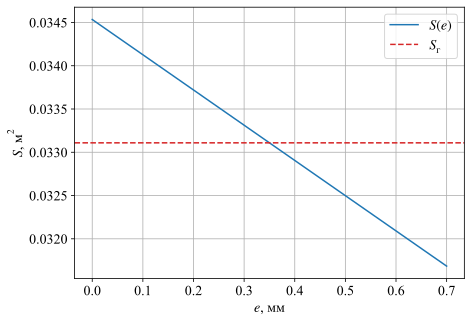

In [15]:
# n_zar_new = n_zar - 7
# n_zar1 = 24; n_zar2 = n_zar_new - n_zar1
# L_zar1 = L_zar + 1e-3
# L_zar2 = (S_g - np.pi * (D_nar + D_vn) * n_zar1 * L_zar1) / (np.pi * (D_nar + D_vn) * n_zar2)
# print(f'Потребная длина заряда второго ряда = {L_zar2*1e3:.1f} мм')

# def S_zar(e):
#     S_zar1 = n_zar1 * (np.pi * (D_vn + 2 * e)*(L_zar1 - 2 * e) + np.pi * (D_nar - 2 * e) * (L_zar1 - 2 * e) + \
#         2 * np.pi * 0.25 * (((D_nar - 2 * e) ** 2) - ((D_vn + 2 * e) ** 2)))
#     S_zar2 = n_zar2 * (np.pi * (D_vn + 2 * e)*(L_zar2 - 2 * e) + np.pi * (D_nar - 2 * e) * (L_zar2 - 2 * e) + \
#         2 * np.pi * 0.25 * (((D_nar - 2 * e) ** 2) - ((D_vn + 2 * e) ** 2)))
#     return S_zar1 + S_zar2

# plt.figure(figsize=(7, 5))
# e0s = np.linspace(0,e_0,100)
# S_zars = [S_zar(e) - 0.002 for e in e0s]
# plt.plot(e0s*1e3,S_zars, c = 'tab:blue', label = '$\mathit{S(e)}$')
# plt.axhline(S_g - 0.002,ls = '--',c = 'tab:red', label = '$\mathit{S}_г$')

# plt.grid()
# plt.legend()
# plt.xlabel('$\mathit{e}$, мм')
# plt.ylabel('$\mathit{S}$, $м^2$')
# plt.savefig('Se.svg', dpi=300, bbox_inches='tight')

# plt.show()

#### Расчет воспламенителя

In [21]:
class Vosplamenitel:
    def __init__(self, F_kr, F_oxl, W_0, e_0 = 2e-3, m = 3) -> None:
        self.R = 314
        self.Q = 3050e3
        self.u = 0.05
        self.k = 1.25
        self.rho = 1700
        self.m = m

        self.t_v = e_0 / self.u
        self.T_v = ((self.k - 1) / self.k) * (self.Q / self.R)
        
        self.p_vsp_50 = self.p_vsp(T_min)
        self.p_max = 1.1 * self.p_vsp_50

        b21 = (self.k - 1) / W_0  *  (propel.nu_t * propel.sigma_t * F_oxl) / self.R
        b22 = self.k / W_0 * A(self.k) * F_kr * np.sqrt(self.R * self.T_v)
        self.b2 = b21 + b22
        
        S0_v1 = self.p_max * self.b2 * ((self.m / (self.t_v * self.b2)) ** (-self.m / (self.t_v * self.b2 - self.m)))
        S0_v2 = (self.k - 1) * self.u * self.rho * self.Q
        self.S0_v = S0_v1 / S0_v2 * W_0
        self.b1 = ((self.k-1) / W_0) * self.rho * self.S0_v * self.u * self.Q

        self.omega = e_0 * self.rho * self.S0_v * ((1 - np.exp(- self.m)) / self.m)

        self.__t_vs = np.linspace(0,0.1,2000)
        self.__p_vs = np.array([self.p_v(t) for t in self.__t_vs])

        self.t_vsp = self.__t_vs[self.__p_vs >= self.p_vsp_50][0]

    def p_vsp(self,T_n):
        """Давление вспышки в зависимости от начальной температуры

        Args:
            T_n (float): начальная температура, К

        Returns:
            p_vsp: давление вспышки, Па
        """
        return propel.c_t * propel.rho / propel.sigma_t * propel.u(1e6, T_n) * self.R * self.T_v * (propel.T_s - T_n) / (self.T_v - propel.T_s)

    def p_v(self,t):
        """Зависимость давления от времени при автономном горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            p: давление, Па
        """
        p1 = p_atm + self.b1 / ((self.m / self.t_v) - self.b2)
        p2 = self.b1 / ((self.m / self.t_v) - self.b2)
        return p1 * np.exp(- self.b2 * t) - p2 * np.exp(- self.m * t / self.t_v)

    def S(self,t):
        """Закон горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            S: площадь горения, м2
        """
        return self.S0_v * np.exp(-self.m * t / self.t_v)

    def get_results(self, figure_filename = 'График p_vospl.svg'):
        """Получение результатов расчета воспламенителя

        Args:
            figure_filename (str, optional): название картинки. Defaults to 'График p_vospl.svg'.
        """
        print(f'Температура продуктов сгорания воспламенителя Tв = {self.T_v:.0f} К\n',
              f'Давление вспышки основного заряда при T_min p_vsp(T_min) = {self.p_vsp_50/1e6:.3f} МПа\n',
              f'Максимальное давление воспламенителя p_max = {self.p_max/1e6:.3f} МПа\n',
              f'Начальная площадь поверхности горения S0в = {self.S0_v:.5f} м2\n',
              f'Масса навески воспламенителя omega_в = {self.omega*1e3:.0f} г\n',
              f'Время воспламенения основного заряда t_v = {self.t_vsp*1e3:.1f} мс')

        plt.figure(figsize=(9, 6))
        plt.plot(self.__t_vs[self.__p_vs >= p_atm], self.__p_vs[self.__p_vs >= p_atm]/1e6)
        plt.axhline(self.p_vsp_50/1e6, linestyle = '--', color = 'tab:red', label = '$\mathit{p}_{всп}$ = '+f'{self.p_vsp_50/1e6:.3f} МПа')

        plt.legend(loc = 'upper right')
        plt.grid()
        plt.xlabel('$\mathit{t}, с$')
        plt.ylabel('$\mathit{p}, МПа$')
        if figure_filename:
            plt.savefig(figure_filename, dpi=300, bbox_inches='tight')

        plt.show()

Начальный свободный объем W0 = 3.517 * 10^5 м3
 Площадь, омываемая ПС F_oxl = 0.0420 м2
Температура продуктов сгорания воспламенителя Tв = 1943 К
 Давление вспышки основного заряда при T_min p_vsp(T_min) = 3.395 МПа
 Максимальное давление воспламенителя p_max = 3.735 МПа
 Начальная площадь поверхности горения S0в = 0.00679 м2
 Масса навески воспламенителя omega_в = 7 г
 Время воспламенения основного заряда t_v = 0.7 мс


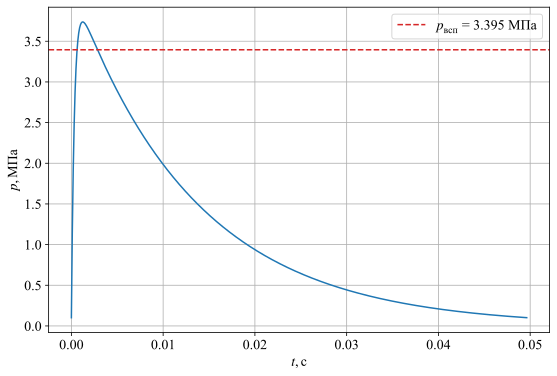

In [22]:
W_0 = np.pi / 4 * (D_km**2) * (27e-3 + D_km/2) - omega_t / propel.rho         # что это за херня??
F_oxl = 1.2 * np.pi * D_km * L_zar + n_zar * np.pi * L_zar * (D_vn + D_nar) + \
        np.pi * n_zar / 2 * (D_nar**2 - D_vn**2)
print(f'Начальный свободный объем W0 = {W_0 * 1e5:.3f} * 10^5 м3\n',
      f'Площадь, омываемая ПС F_oxl = {F_oxl:.4f} м2')

vospl = Vosplamenitel(F_kr,F_oxl,W_0)
vospl.get_results()

In [23]:
# длина трубки ФВУ
print(f'{7e-3 / (np.pi * (13e-3 - 2*1.2e-3)**2 / 4 * vospl.rho) * 1e3:.1f} мм')

46.7 мм


#### ОЗВБ

In [24]:
mu_c = 0.95
e_max = e_0
Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0

def S_zar(e):
    return n_zar * (np.pi * (D_vn + e)*(L_zar - e) + np.pi * (D_nar - e) * (L_zar - e) + \
        2 * np.pi * 0.25 * (((D_nar - e) ** 2) - ((D_vn + e) ** 2)))

In [25]:
def sys_int(t, Y, T0, p_vsp):

    p, W, e_t = Y
    U = np.zeros(3)

    Hev_v = 1 if t <= vospl.t_v else 0
    Hev_p = 1 if p > p_vsp or abs(e_t) > 0 else 0
    Hev_e = 1 if 0 <= abs(e_t) <= e_max else 0

    u_g = propel.u(p,T0)
    S_g = S_zar(abs(e_t))

    #domega_v/dt
    G_v = vospl.S(t) * vospl.u * vospl.rho * Hev_v

    #dp/dt
    p1 = (propel.k - 1) * vospl.Q / (propel.rho * S_g * u_g) * G_v + (propel.k - 1) * Q_t * Hev_e
    p2 = propel.k * (mu_c * A(propel.k) * F_kr * p / (propel.rho * S_g * u_g)) ** 2
    p3 = (propel.k - 1) * propel.sigma_t * propel.nu_t * F_oxl * p / (propel.R * propel.rho * S_g * u_g)
    p4 = propel.k * p / (vospl.rho * propel.rho * S_g * u_g) * G_v
    p5 = propel.k * p / propel.rho * Hev_e
    U[0] = (p1 - p2 - p3 - p4 - p5) * propel.rho * S_g * u_g / W

    #de/dt
    U[2] = u_g * Hev_p * Hev_e

    #domega_t/dt
    G_t = S_g * propel.rho * U[2]

    #dW/dt
    U[1] = 1 / propel.rho * G_t + 1 / vospl.rho * G_v

    return U

def res_int(T0):

    stop = lambda p: p * pi(1,propel.k) <= p_atm
    # stop = lambda p: p <= p_atm

    Y_0 = [0, p_atm, W_0, 0]

    result = dict()
    keys = ['t','p','W','e_t']
    for key, val in zip(keys,Y_0):
        result[key] = np.array([val])

    r = ode(sys_int).set_integrator('vode', method = 'adams')     #'vode', method = 'adams'
    r.set_initial_value(Y_0[1:])
    r.set_f_params(T0, vospl.p_vsp(T0))

    while r.successful() and (not stop(result['p'][-1]) or result['t'][-1] < 0.005):
        dt = 5e-6
        result['t'] = np.append(result['t'], result['t'][-1] + dt)
        Y_tek = r.integrate(r.t+dt)
        for key, val in zip(keys[1:],Y_tek):
            result[key] = np.append(result[key], val)

    result['T_n'] = T0

    return result

In [26]:
res18 = res_int(T_nom)
res50 = res_int(T_max)
res_50 = res_int(T_min)

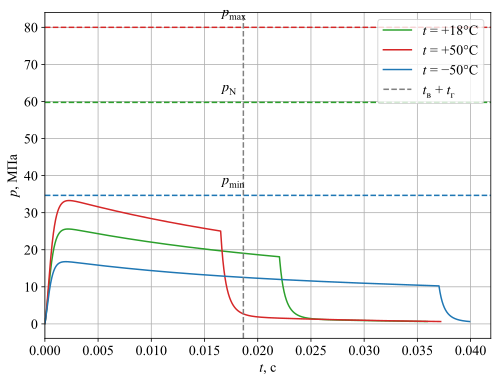

In [27]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'],res18['p']/1e6, c = 'tab:green', label = '$\mathit{t}$ = +18°C')
plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
plt.axhline(p1_min/1e6,ls = '--',c = 'tab:blue')
plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
plt.plot(res50['t'],res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
plt.plot(res_50['t'],res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')

plt.xlim(0)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()

In [28]:
G_ts = lambda res: np.array([S_zar(abs(e_t)) * propel.rho * propel.u(p,res['T_n']) for e_t, p in zip(res['e_t'],res['p'])])
Ps = lambda res: np.array([G_t * V_a + np.pi * zeta * D_kr**2 / 4 * (p * pi(lambda_a,propel.k) - p_atm) for G_t, p in zip(G_ts(res),res['p'])])

I_sumf = lambda res: simpson(Ps(res),res['t'])

# Импульсы
I_sumf(res_50), I_sumf(res18), I_sumf(res50), I_kor

(94.801529304912, 101.13404559321545, 107.41026721915364, 140)

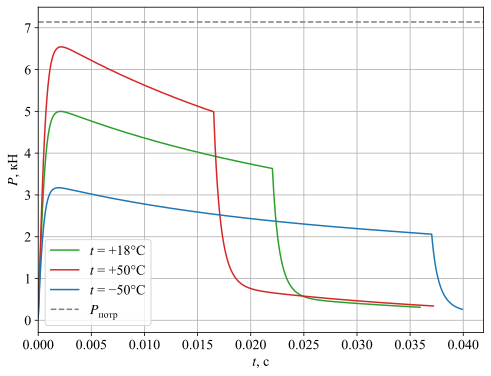

In [29]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'],Ps(res18)/1e3, c = 'tab:green', label = '$\mathit{t}$ = +18°C')
plt.plot(res50['t'],Ps(res50)/1e3, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
plt.plot(res_50['t'],Ps(res_50)/1e3, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
plt.axhline(P_need/1e3,ls = '--',c = 'grey', label = '$\mathit{P}_{потр}$')

plt.xlim(0)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{P}$, кН')
plt.legend()
plt.grid()
plt.savefig('Инд Pp.svg', dpi=500, bbox_inches='tight')

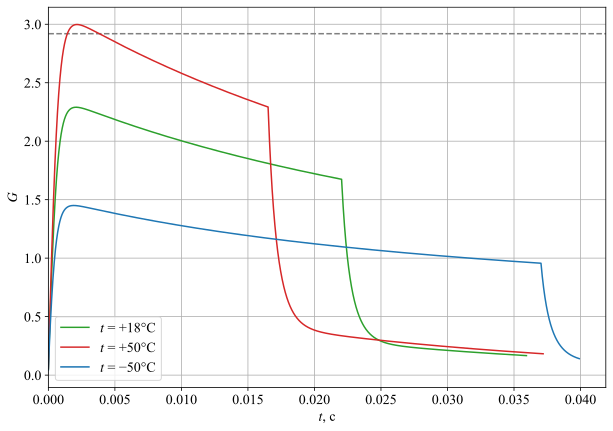

In [30]:
plt.figure(figsize = (10,7))
plt.plot(res18['t'],G_ts(res18), c = 'tab:green', label = '$\mathit{t}$ = +18°C')
plt.axhline(G_p,ls = '--',c = 'grey')
plt.plot(res50['t'],G_ts(res50), c = 'tab:red', label = '$\mathit{t}$ = +50°C')
plt.plot(res_50['t'],G_ts(res_50), c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')

plt.xlim(0)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{G}$')
plt.legend()
plt.grid()